In [1287]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
from scipy.linalg import sqrtm
import pandas as pd
np.random.seed(1234)

In [1380]:
#Muller Brown Potential and Gradient

def MB_potential(x,y):    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    value = 0
    for j in range(0, 4):
        value += AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return value
vMB_potential = np.vectorize(Muller_Brown_potential)

def grad_MB(x,y):
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    dx = 0
    dy = 0
    for j in range(0, 4):
        dx += AA[j] *(2*aa[j]*(x-XX[j])+bb[j]*(y-YY[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
        dy += AA[j] *(2*cc[j]*(y-YY[j])+bb[j]*(x-XX[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return dx, dy
vgrad_MB = np.vectorize(grad_MB)

def Hessian_MB(x,y):
    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    dxx = 0
    dxy = 0
    dyy = 0
    for j in range(0, 4):
        Phi = AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
        alpha = (2*aa[j]*(x-XX[j])+bb[j]*(y-YY[j]))
        beta = (2*cc[j]*(y-YY[j])+bb[j]*(x-XX[j]))
        dxx += 2*aa[j]*Phi + alpha**2*Phi
        dxy += bb[j]*Phi + bb[j]*(y-YY[j])*beta*Phi
        dyy += 2*cc[j]*Phi + beta**2*Phi
        
    return dxx, dxy, dxy, dyy
vHessian_MB = np.vectorize(Hessian_MB)

In [1502]:
def affine_invariant_wd(N = 5000, learning_rate = 1e-4, mu = 0, sigma = 1):
    intervals = np.arange(1, 1e5, 20)
    #initialise variables (particles)
    dt = learning_rate
    C = sigma**2*np.identity(2)
    mean = np.array([0.2, 1.2])
    x,y = np.random.multivariate_normal(mean, C)
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    points_x = [x]
    points_y = [y]
    
    beta = 10
    
    for i in trange(1, N+1):
        
        grad = grad_MB(x,y)
        
        dx,dy = - C@grad/beta*dt + np.sqrt(2)*sqrtm(C)@np.random.normal(0,dt,2) - np.array([2*x, 2*y])*dt
        x += dx
        y += dy
        if i in intervals: 
            points_x.append(x)
            points_y.append(y)

        Z = np.random.multivariate_normal(mean, C, int(1e3))
        X = Z[:,0]
        Y = Z[:,1]
        Dx, Dy = vgrad_MB(X,Y)
        exp_m = np.array([np.mean(Dx), np.mean(Dy)])/beta
        
        Dxx, Dxy, Dyx, Dyy = vHessian_MB(X,Y)
        dxx = np.mean(Dxx)
        dxy = np.mean(Dxy)
        dyx = dxy
        dyy = np.mean(Dyy)
        exp_c = np.array([[dxx, dxy], [dyx, dyy]])/beta**2
        #update mean and covariance matrix
        mean = mean-C@exp_m*dt
        C = C + 2*C*dt-2*C@exp_c@C*dt
        print(x,y)
        
    return points_x, points_y, mean,C

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

-1.219019181323796 1.8345375268999444
-1.194633733528973 1.7978568724826771
-1.170742806308835 1.7618959995479675
-1.1473357628463545 1.726647285010563
-1.124383759460204 1.6921231580123042
-1.1019128156324378 1.658241839093831
-1.079884505084907 1.6250779497296415
-1.0582973291443973 1.5925502120252477
-1.0371179050791928 1.5606914602423914
-1.0163710680481004 1.5294823857075452
-0.9960512370279248 1.4988611316066607
-0.9761550927543664 1.4688525336343896
-0.9566225777026494 1.4394553597420991
-0.9374980924011211 1.4106594374214187
-0.918704360807792 1.3824399253581574
-0.9003125181700985 1.3547902374876424
-0.8823344263949457 1.3276804325433111
-0.8646838728773591 1.3011126728423887
-0.8473793398166597 1.2750998062009475
-0.8304122204216076 1.249595709421411
-0.8138235351636759 1.2245800700051623
-0.7975414281790318 1.2001390959210207
-0.7815612742401798 1.1761165528013264
-0.7659045172177678 1.1525940840803086
-0.7506071074706215 1.1295242436521562
-0.735598118142808 1.1069106432950

-0.017189884206286744 0.026969788440472136
-0.016970701871470376 0.026559778899260148
-0.016601758907361718 0.025941303275507886
-0.016208067245265086 0.025489346450892434
-0.015822491402575935 0.024898964746583888
-0.015413326389640795 0.024484466191688273
-0.015050046343453503 0.02394884961162022
-0.01460635747967621 0.023459769922985665
-0.014701581619124781 0.02314314492957987
-0.014638649685736322 0.022616372970690437
-0.014167947249280862 0.02226800207905725
-0.013873271200651646 0.021714921990230708
-0.013637095978362884 0.02121913035906729
-0.01322440333022737 0.020811925897873278
-0.013157873985383902 0.020529200187010436
-0.01309130907272062 0.020066517809950887
-0.013005529083787234 0.01949048259786121
-0.012853877455890448 0.018992961167007483
-0.012495856096030317 0.018745913803793476
-0.012079113275188668 0.01850221062576478
-0.011791204215945384 0.018237879845768978
-0.011712127461838815 0.017996561760685995
-0.011423494675348277 0.017693137353562025
-0.01125604494567799

0.009680102969046502 0.0038043048575405703
0.009239962137458346 0.0043369630227612695
0.010130268632734054 0.005173230854196377
0.008181676022972968 0.0045729651757724955
0.008281431337030753 0.004697668908505562
0.009661840643697515 0.006260887160399116
0.011258007767662774 0.007217765647992855
0.011186308198994147 0.006092234141365316
0.012039927624283492 0.0066415597318828035
0.011805332867574202 0.0072343428354561794
0.010982897055538288 0.007350044533561303
0.010836801860007796 0.006702600646035563
0.012569029234208284 0.00723743008871282
0.012647121632587863 0.007324969957221985
0.012947538760008717 0.008461657190867545
0.013102436947340602 0.007779694047754045
0.013183682461759804 0.008244351019122716
0.012677116991126312 0.010321299848328618
0.013108443455294555 0.010835365638240684
0.012548043274354862 0.011031388403867635
0.011930228127093599 0.011303955084956836
0.011830991603293175 0.011612514048127772
0.012224443987222732 0.011625817808174923
0.012831225488482189 0.0119354

0.39449469397977066 0.04261811799148806
0.39459484833847774 0.057051988974229584
0.39917068473262934 0.05797917493274114
0.40093185744320936 0.03881107872554558
0.41072736938962107 0.03426640486901565
0.41746019486586006 0.03292419356774417
0.4171641469997135 0.038689301435212355
0.4221822716696439 0.049398386082013065
0.43264312191871457 0.03406542962305496
0.43726203084289417 0.03858728608834971
0.44106900789763476 0.03321421125419088
0.44492068477449653 0.046086981084746126
0.4492003853677685 0.053822724086551525
0.4490992836697251 0.03770661592659278
0.45807974915889754 0.03802543296669664
0.4663367035909275 0.03195543767945275
0.4656059685325971 0.034743493484234125
0.4579442454152422 0.028207751636071733
0.4574359513851111 0.04138575126466976
0.4646788862179043 0.031093166553222466
0.4755820725418824 0.030313010658869443
0.49087158593398206 0.03345045605935544
0.49659934139619927 0.04239342330063439
0.5080716696189648 0.04101516056835524
0.5035955325225243 0.03212402291607309
0.5

0.5465186993063615 0.026628612735038124
0.5389321462067951 0.014611431544528503
0.5349472187476437 0.035045601135502716
0.5487285495770532 0.03716592903130948
0.5587472063888329 0.019199906318145523
0.5524795381827714 0.03105027290652207
0.5532247862915551 0.020566940659094552
0.5553093354165762 0.025214030288744235
0.5563809541743955 0.03833768464212376
0.5609575142128199 0.03476018609496073
0.5689050845088591 0.025580724524696962
0.5607299136295504 0.028993825504441916
0.5616085299156361 0.03568045356116679
0.5635640019543514 0.015373407436663752
0.5647399494766371 0.03583530733329057
0.5723703282352047 0.027995622468940235
0.5743987116003887 0.0228071110386255
0.5755486800315193 0.03480755469073955
0.5657391238916358 0.032417361080686415
0.5697778269254713 0.03292385900289597
0.5719924482702916 0.033160644493332656
0.5723083550721735 0.019141725396944524
0.584453350893277 0.02581426133399332
0.5749942061842799 0.02672400920500644
0.5769204213163466 0.02660736685851885
0.571084982897

  0%|          | 0/1000 [00:00<?, ?it/s]

-1.4611615794812167 -0.16740485760226922
-1.4319118484779645 -0.16406906730990134
-1.4032882863627087 -0.16080509659069925
-1.375222057916449 -0.15758477081943467
-1.3477082072620645 -0.15444303180437755
-1.3207402518379945 -0.15135978608925565
-1.2943386199060583 -0.14830855458048103
-1.2684576471256441 -0.14532805185690245
-1.2430721487632237 -0.14239145487263308
-1.2182236116189846 -0.13956126262344776
-1.1938403566963707 -0.13675629662321168
-1.1699861695191864 -0.1340086303750169
-1.1465895238563233 -0.13132987814040906
-1.1236499800860147 -0.12871909851524857
-1.1011987780737535 -0.12613709207168386
-1.0791805769775058 -0.12360192774861313
-1.0575821536830412 -0.12113026114578343
-1.036412514638233 -0.11869122005057561
-1.0156772272464596 -0.11633258566393817
-0.9953727806763313 -0.11403360118194927
-0.9754466841467127 -0.11174661581840029
-0.955961537630236 -0.10951246875082243
-0.9368292896794537 -0.10730657234185571
-0.9180988765395262 -0.10515017572578444
-0.899756682143287 -

-0.024796574487419534 -0.0028968803716318374
-0.02438073756104516 -0.0028279244755695775
-0.02382811824844676 -0.002729557749011707
-0.023487377178784987 -0.002712546347136178
-0.023030523557097424 -0.0025658055606647867
-0.022583571199157246 -0.0024058736776901312
-0.022342026015414566 -0.0024393359727569322
-0.021806375708213015 -0.0024475637131206973
-0.02131808996509423 -0.002426665644515144
-0.020926410770723856 -0.0022125827496880445
-0.020517799102538033 -0.0020956192754162405
-0.02019251272069483 -0.0020714209054257487
-0.019684538989089374 -0.002053696105880358
-0.01940334628352805 -0.00203625930410486
-0.019022407359071195 -0.001991855911867088
-0.01871862364662445 -0.0020357741281878615
-0.018177215720189998 -0.0021216867406571157
-0.017979455252926487 -0.0020105901721201203
-0.01768888033870471 -0.0018397637153966832
-0.017306364487638417 -0.001733790095810839
-0.016946196216975656 -0.0016751838960396192
-0.01646642366840545 -0.0017960911846300668
-0.016094664419014942 -0.0

0.0065205150091137976 0.010177616491121718
0.005364230225925555 0.009848957871948182
0.00565171890250605 0.009899300261375464
0.0054231788625121865 0.009679466225038626
0.005093390110790664 0.009489563666237032
0.004381200581936662 0.00880513579525983
0.004797253111412385 0.00830797545688382
0.0041265367060571104 0.009105748636470037
0.005357390012325605 0.009710593208625943
0.005077208391504158 0.009382865857945193
0.006349090150311183 0.009985569788890992
0.0068020222044128924 0.009893626722962654
0.007628237861726608 0.009533323451424719
0.008238304709666883 0.010821526842604156
0.007462000306590735 0.00977416560389205
0.008282225259145742 0.011438964870327067
0.00928036483525365 0.01111669871310993
0.008485229904406703 0.012192853260633433
0.01048887154902942 0.01172322762962985
0.011475359764164219 0.011722815419171178
0.010799712222369737 0.011085867931170664
0.010976557323826571 0.011293494127342391
0.012315749983166072 0.012191772444585938
0.01234250885467224 0.0122845935983771

0.39035182673652175 0.03349313279346821
0.3914416181705829 0.03774177786906396
0.39858911265473335 0.03760625949502259
0.4004433393651001 0.03414002666916724
0.3980397520176572 0.04029813184222408
0.41639399376151764 0.04828976399296468
0.41679498364632594 0.05139211876092919
0.4281998809341889 0.04691485309345315
0.43426376808935724 0.0408216270828595
0.43605049673829976 0.03254466855334294
0.44287257317123563 0.03693107455750337
0.4503702791431233 0.04028282367377948
0.446153074861014 0.039516168389737295
0.4452331511941532 0.04050521675835128
0.44887059986246636 0.04118937875231903
0.45478981022889764 0.04570937786106517
0.4620471508880196 0.04080878408913189
0.4623724458009067 0.035516644486011086
0.4684083623179617 0.041698921220774225
0.47109663301275967 0.04620486657148298
0.47357745485718106 0.03621385805594275
0.4693141715098737 0.03414246022497168
0.47931478553487233 0.038660007371458104
0.4851365696219031 0.03461025355130174
0.4967824867037244 0.03251472533316382
0.503734083

0.5868405912080332 0.029847797446690798
0.5621997524297951 0.02319362630916609
0.5653045054197604 0.021620313470224025
0.5643406475154886 0.028905531318942527
0.5596887526805253 0.034223238865394856
0.571021534336003 0.02712572263132012
0.5707805819306188 0.024831825556304706
0.5571291997000523 0.03791960587399193
0.564873209162178 0.038332132405141654
0.5661780545850059 0.03131658830150609
0.5772253774175049 0.02767827920451861
0.5874007735072856 0.01973681865533132
0.5929712683992993 0.01752352183664139
0.5811646249096412 0.04297862222096322
0.5884772225605007 0.018351023021061282
0.5749409457703863 0.03593020198704161
0.5799010073734157 0.01676175444678324
0.5794483162439416 0.04249851164842759
0.5750419059432242 0.017008253064218284
0.5893972693716735 0.02745980113266631
0.5774485374783029 0.026213009017606127
0.5752626727250519 0.028353786958564987
0.5815393046471724 0.03144102147396064
0.5820071377620587 0.02237284189777678
0.5926060316615475 0.04677142290272659
0.592017520061948

  0%|          | 0/1000 [00:00<?, ?it/s]

0.024666961090686747 0.10269453640598455
0.024175080083114787 0.10061784029238063
0.023685560885661695 0.09857711015435569
0.023215981995565717 0.0966194800822092
0.02277883756959548 0.09468783508806938
0.02232252393453538 0.09280329728164285
0.021874209716648017 0.0909528739253004
0.02145115289855689 0.08910961262987824
0.02105740824652218 0.08733189697414745
0.020653530640409985 0.0855765252187966
0.02025399909002831 0.0838714175198146
0.019833644310266428 0.08220415018739166
0.019421042476828076 0.08056069360592763
0.019024718013378107 0.07893327668929835
0.01863150593370275 0.07735583338428162
0.018297994013430872 0.07578485712493192
0.01793069182075789 0.07425036550634542
0.017602043048725334 0.07277713576213823
0.01723880565223001 0.07130943947396996
0.016877780524935188 0.06991484670755155
0.016521732925342827 0.06850364540500575
0.016191017757317575 0.06713001045667913
0.015900487895063674 0.06580193317976243
0.015581679255750307 0.06447242643083324
0.015286411265773481 0.06318

0.0007979986892248463 0.0022537653119550642
0.0007391840169721859 0.0021878688392268303
0.000788259216846931 0.0022740905875270404
0.0007609959629122589 0.0021278146517893955
0.0008255100084809208 0.002135229807711399
0.000753970015578793 0.002108201416302661
0.0009662193531694487 0.0020292717053628424
0.000959913117509174 0.0020427562073493653
0.000663504888317052 0.0019680118170136212
0.0005157658119386273 0.0018884705502874026
0.0006166787162912814 0.0018885270115129367
0.0007546193321578042 0.0018351894122487628
0.0008656680463536836 0.001759807462248012
0.0010959126382513284 0.0018390560345871913
0.001071354247230664 0.0017328942391991234
0.0011653136879845693 0.0015972610931127768
0.0012900509720881578 0.0016328362450532795
0.001364835786840659 0.001500327322657705
0.0014828381677284197 0.0016051516071681295
0.0015113625622182134 0.0013921634997865532
0.0012634127744415814 0.0011425702882709079
0.001440382651037607 0.0013043512919648519
0.0015617503209793939 0.001222871909853852


0.004451064044477076 0.0024659328198535853
0.004694768631522086 0.0025916126617955963
0.006153003868227146 0.0026826502173010547
0.006960229387430258 0.003185008188081864
0.006018924736404354 0.002895558595672443
0.005885619953856362 0.0034431816305058884
0.006286189342530628 0.0029182078198720374
0.005681547477611016 0.0022834839642474156
0.00611906069718299 0.001957194472893613
0.005152212484174715 0.002385767014749058
0.00592200199593663 0.0028799903343465806
0.006655784339263703 0.0032172423735025418
0.007772712266641518 0.003391762760089976
0.008235201200125114 0.0033025557266469553
0.008111348568155282 0.004742461704557915
0.009186537739796441 0.004736236046303184
0.00980267098149883 0.004663795013560898
0.010915674959592751 0.004869037218702862
0.011816889797357767 0.0057056001453226314
0.011168520243263884 0.006097395292445271
0.011098856124777106 0.008442604434098073
0.011908462621350981 0.007851244336394144
0.013113751439880906 0.007825082965602446
0.012584360698983813 0.0080

0.3247447309768422 0.05287183685231859
0.32717323521650304 0.05148004099439708
0.3374414527469312 0.04918928601508466
0.3442642476330136 0.043217470519440554
0.3540471936824668 0.047504650163162035
0.35730131224964057 0.05647611094891531
0.3683059858142461 0.05051839112248368
0.3708427969149342 0.04683614895146491
0.38449141300926665 0.05070430051707529
0.3863690978413355 0.05386972548411034
0.3765976319486018 0.03645862586221534
0.3717387145550767 0.03064488863695844
0.37662245737168 0.017785534086316387
0.3709767342383529 0.0342005549102296
0.3711673541453168 0.04629419129636589
0.38110330256327063 0.049589224597009665
0.3926540677940663 0.04554007264169716
0.39571704740434005 0.055800548001610266
0.3922471967499289 0.05089279286537458
0.3905313885159234 0.058904148109914144
0.39715536472855334 0.05252718257223887
0.404894673869907 0.035262800633345845
0.40716084923197815 0.03352384869691651
0.40535931102525036 0.04238747033231753
0.4076627336629777 0.05459154093961083
0.410613566767

0.5751325342520746 0.03635175923714949
0.5780385026853028 0.027093954964283583
0.5828824664997071 0.044639412398692825
0.5870211433422932 0.024901677243383515
0.5612378610822889 0.02876489974513035
0.5755551394344613 0.02956920656921885
0.5614692902282644 0.03591845165685107
0.5495808372662155 0.031851489809462265
0.565192932226391 0.016946891589730624
0.5612949643164076 0.04499340734702331
0.5809886477359003 0.005339345523013676
0.5764414435747189 0.02388387303365322
0.5697660074766984 0.02803351646002595
0.5670132770608992 0.04349746913447788
0.566916403409692 0.03837144202710123
0.5613061084926894 0.013721803771825185
0.5711078806859698 0.03267187003715153
0.5648935945829036 0.03776070575017858
0.5607764623955653 0.02021026277802323
0.5418631370759041 0.040418658268120994
0.54853170080562 0.04356531852893318
0.5401012087045232 0.023851163986649663
0.5400245557145432 0.040447772628719875
0.5465932924280009 0.04273708153582997
0.5540783888373045 0.037553452687926134
0.5510997229047281

/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/3674676880.py:26: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = np.random.multivariate_normal(mean, C, int(1e3))
/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/214911526.py:29: RuntimeWarning: overflow encountered in scalar power
  dx += AA[j] *(2*aa[j]*(x-XX[j])+bb[j]*(y-YY[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/214911526.py:30: RuntimeWarning: overflow encountered in scalar power
  bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/214911526.py:31: RuntimeWarning: overflow encountered in scalar power
  dy += AA[j] *(2*cc[j]*(y-YY[j])+bb[j]*(x-XX[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/214911526.py:32: RuntimeWarning: overflow encountered in scalar power
  bb[j] * (x - XX[j])

OverflowError: (34, 'Result too large')

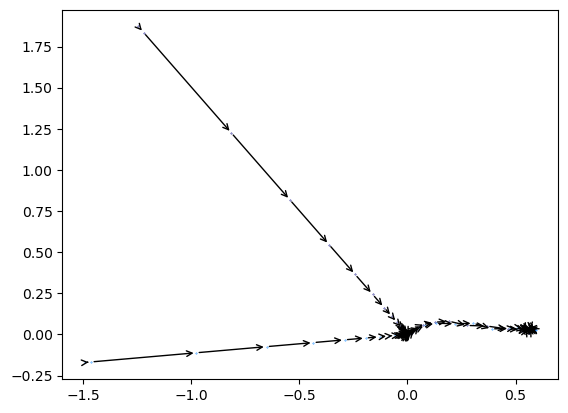

In [1504]:
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 5
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima = []
for j in tqdm(range(ntraj)):
    points_x, points_y, mean,C = affine_invariant_wd(N = 1000, learning_rate = 1e-2, mu = 0, sigma = 1e-3)
    minima.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6 : 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                 arrowprops={'arrowstyle': '->',  'lw': 1},
                 va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Affine Invariant Gradient Flow ')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

(array([16.99441318,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 16.99441318]),
 array([-106.90006712, -106.87064569, -106.84122426, -106.81180282,
        -106.78238139, -106.75295995, -106.72353852, -106.69411709,
        -106.66469565, -106.63527422, -106.60585279]),
 <BarContainer object of 10 artists>)

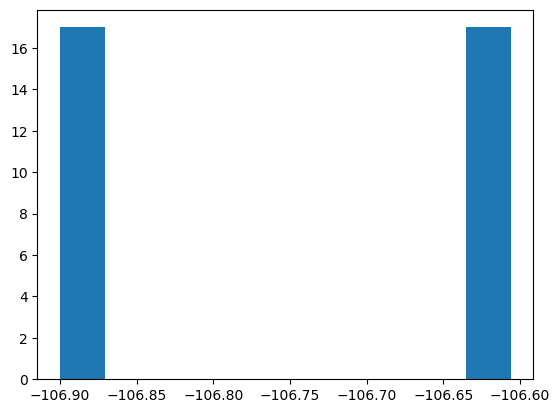

In [1505]:
bins = np.linspace(-150,10,5)
plt.hist(minima, density = 'True')

In [1487]:
# Training
def train(intervals, N = 5000, learning_rate = 1e-3, a = 1, tolerance = 1e-2):
    #initialise data
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    i = 1
    while 1<=i<=N+1:
        dx, dy = grad_MB(x,y)
        x1 = x - learning_rate*dx
        y1 = y - learning_rate*dy
        #err = np.abs(x1-x)+np.abs(y1-y)
        x = x1
        y = y1
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
        

    return points_x, points_y

def train_nesterov(intervals, N = 5000, learning_rate = 1e-3, a = 1, tolerance = 1e-2):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    u = x
    v = y
    i = 1
    
    while 1<=i<=N+1:
        dx, dy = grad_MB(u,v)
        
        x_new = u - learning_rate*dx
        y_new = v - learning_rate*dy
        
        u = x_new + (i-1)/(i+2)*(x_new-x)
        v = y_new + (i-1)/(i+2)*(y_new-y)
        
        #err = np.abs(x_new-x)+np.abs(y_new-y)
        
        x = x_new
        y = y_new
        
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    
    return points_x, points_y

def train_MaSS(intervals, N = 5000, learning_rate = 1e-3, a = 1, tolerance = 1e-2):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    u = x
    v = y
    i = 1
    count = 1
    
    while 1<=i<=N+1:
        dx, dy = grad_MB(u,v)
        
        m = 10
        eta2 = learning_rate/m
        
        x_new = u - learning_rate*dx
        y_new = v - learning_rate*dy
        
        u = x_new + (count-1)/(count+2)*(x_new-x) + eta2*dx
        v = y_new + (count-1)/(count+2)*(y_new-y) + eta2*dy
        
        if dx*(x_new-x)+dy*(y_new-y)>0: 
            count = 1
        
        x = x_new
        y = y_new
        
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    
    return points_x, points_y

def train_sgd(intervals, N = 5000, learning_rate = 1e-3, a = 1, beta = 1, tolerance = 1e-2):
    #initialise data
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    err = np.inf
    i = 1
    while 1<=i<=N+1:
        dx, dy = grad_MB(x,y)
        x1 = x - learning_rate*dx + np.sqrt(2/beta)*np.sqrt(learning_rate)*np.random.normal(0,1)
        y1 = y - learning_rate*dy + np.sqrt(2/beta)*np.sqrt(learning_rate)*np.random.normal(0,1)
        x = x1
        y = y1
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
        
    return points_x, points_y

def train_MF_Hom_SGLD(intervals, N = 5000, learning_rate = 1e-3, M = 20, tolerance = 1e-2):
    
    #initialise data
    intervals = np.arange(1, 1e5, 20)
    #sample from data
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    points_x = []
    points_y = []
    
    Y_x = 0
    Y_y = 0
        
    i = 1
    
    while 1<=i<=N+1:
        
        #update Y
        Y_x_1 = Y_x
        Y_y_1 = Y_y
        
        cal_Y_x = 0
        cal_Y_y = 0
        
        for m in range(1,M+1):
            δ = 0.01/20
            γ = 0.05
            β = 0.1
            λ = 0.05
        
            dx, dy = grad_MB(Y_x_1,Y_y_1)
            
            Y_x_1 = Y_x_1 - δ*(dx-(1/γ)*(x-Y_x_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1)
            Y_y_1 = Y_y_1 - δ*(dy-(1/γ)*(y-Y_y_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1)
            
            cal_Y_x += Y_x_1
            cal_Y_y += Y_y_1
            
        Y_x = Y_x_1
        Y_y = Y_y_1
        
        cal_Y_x /= M
        cal_Y_y /= M
        
        #update model parameters
        Δ = learning_rate
        mu = (x+y)/2
        
        x = x - 1/γ*(x-cal_Y_x)*Δ - λ*(x - mu)*Δ
        y = y - 1/γ*(y-cal_Y_y)*Δ - λ*(y - mu)*Δ
                
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    return points_x, points_y

def train_HJB(intervals, N = 5000, learning_rate = 1e-3, a = 1, L = 20, test = 'False'):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    u = x
    v = y
    
    #regularise potential 

    i = 1
    count = 1
    gamma_0 = 0.2
    gamma_1 = 1e-4
    gamma = gamma_0
    
    while 1<=i<=N+1:
        
        if i%L**2 == 0:
            gamma = gamma_0*(1-gamma_1)**(i/L)
        
        heat_x = np.random.normal(0,gamma,L)
        heat_y = gamma*np.random.normal(0,gamma,L)
        
        potential = np.exp(-vMB_potential(u+heat_x, v+heat_y))
        prob = potential/np.sum(potential)

        Dx, Dy = vgrad_MB(u+heat_x,v+heat_y)
        
        dx = np.sum(Dx*prob)
        dy = np.sum(Dy*prob)
        
        x_new = u - learning_rate*dx
        y_new = v - learning_rate*dy
        
        u = x_new + (count-1)/(count+2)*(x_new-x)
        v = y_new + (count-1)/(count+2)*(y_new-y)
        
        if dx*(x_new-x)+dy*(y_new-y)>0: 
            count = 1
        
        x = x_new
        y = y_new
        
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            if test == 'True':
                print('Epoch: {}'.format(i))
                print('x: {}'.format(x))
                print('y: {}'.format(y))
            
        i+=1
    
    return points_x, points_y

def train_HGD(intervals, N = 5000, learning_rate = 1e-4, a = 1, L = 20):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    i = 1
    
    gamma_0 = 0.3
    gamma_1 = 1e-1
    gamma = gamma_0
    
    while 1<=i<=N+1:
        if i%L**2 == 0:
            gamma = gamma_0*(1-gamma_1)**(i/L**2)
            

        heat_x = gamma*np.random.normal(0,1,L)
        heat_y = gamma*np.random.normal(0,1,L)
        
        potential = np.exp(-vMB_potential(x+heat_x, y+heat_y))
        prob = potential/np.sum(potential)

        Dx, Dy = vgrad_MB(x+heat_x,y+heat_y)
        
        dx = np.sum(Dx*prob)
        dy = np.sum(Dy*prob)
        
        x -= learning_rate*dx
        y -= learning_rate*dy
    
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    
    return points_x, points_y

  0%|          | 0/20 [00:00<?, ?it/s]

([], [])

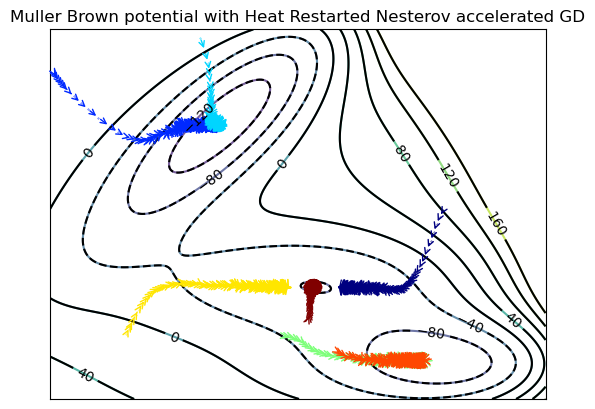

In [1488]:
#Heat Restarted Nesterov with HJB regularised Potential 
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 20
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_HJB = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_HJB(intervals, learning_rate = 1e-5, a = 1)
    minima_HJB.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6: 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x)-1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with Heat Restarted Nesterov accelerated GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

(array([0.09, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.  ,
        0.  , 0.  , 0.08, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 array([-150., -145., -140., -135., -130., -125., -120., -115., -110.,
        -105., -100.,  -95.,  -90.,  -85.,  -80.,  -75.,  -70.,  -65.,
         -60.,  -55.,  -50.,  -45.,  -40.,  -35.,  -30.,  -25.,  -20.,
         -15.,  -10.,   -5.,    0.,    5.]),
 <BarContainer object of 31 artists>)

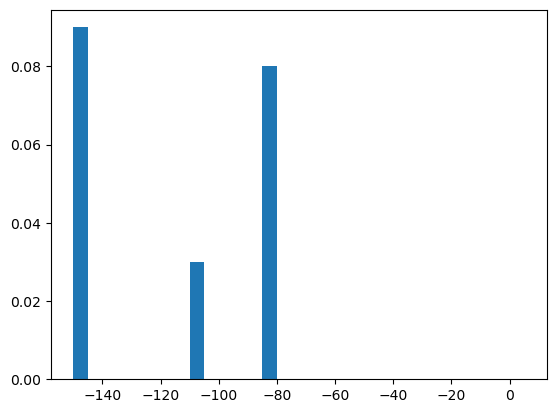

In [1486]:
bins = np.arange(-150, 10, 5)
plt.hist(minima_HJB, bins = bins, density = 'True')

  0%|          | 0/20 [00:00<?, ?it/s]

([], [])

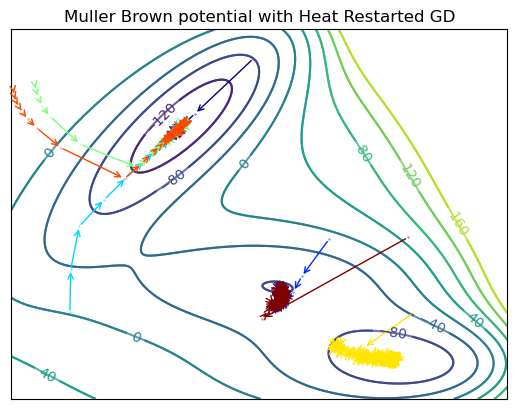

In [848]:
#Heat Restarted GD
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 20
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_HGD = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_HGD(intervals, learning_rate = 1e-4, a = 1)
    minima_HGD.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6 : 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j], 'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Muller Brown potential with Heat Restarted GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

In [696]:
#Vanilla GD
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_vanilla = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train(intervals, learning_rate = 1e-4, a = 1, tolerance = 1e-5)
    minima_vanilla.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6 : 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j], 'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Muller Brown potential with vanilla GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

([], [])

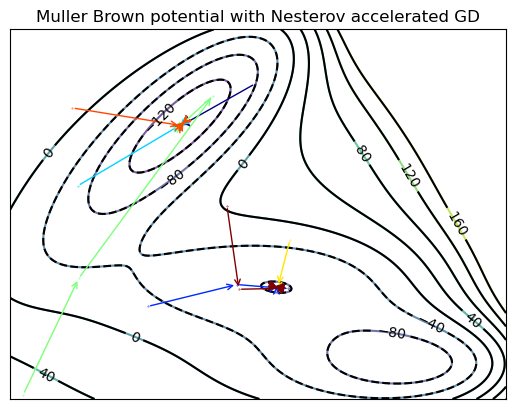

In [617]:
#Nesterov Potential 
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_nesterov = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_nesterov(intervals, learning_rate = 1e-4, a = 1, tolerance = 1e-5)
    minima_nesterov.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6: 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x)-1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Muller Brown potential with Nesterov accelerated GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/100 [00:00<?, ?it/s]

([], [])

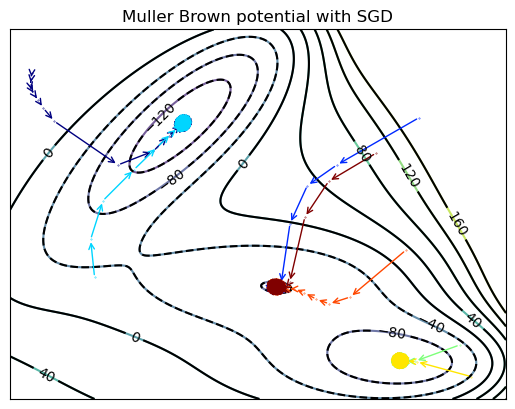

In [1492]:
#sgd

n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 100
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_sgd = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_sgd(intervals, learning_rate = 1e-4, a = 1, beta = 100, tolerance = 1e-5)
    minima_sgd.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6:
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with SGD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

([], [])

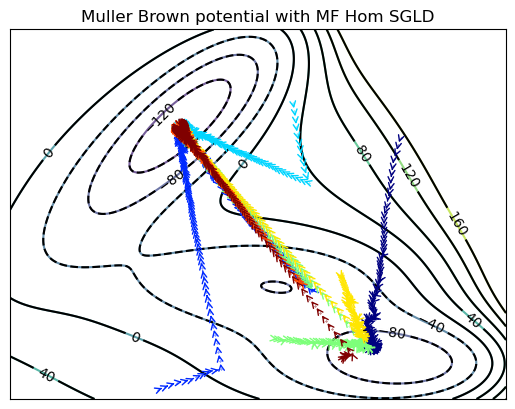

In [625]:
#MF Hom SGLD

n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_MF_Hom_SGLD = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_MF_Hom_SGLD(intervals, learning_rate = 1e-4, M = 20)
    minima_MF_Hom_SGLD.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6:
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with MF Hom SGLD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/20 [00:00<?, ?it/s]

([], [])

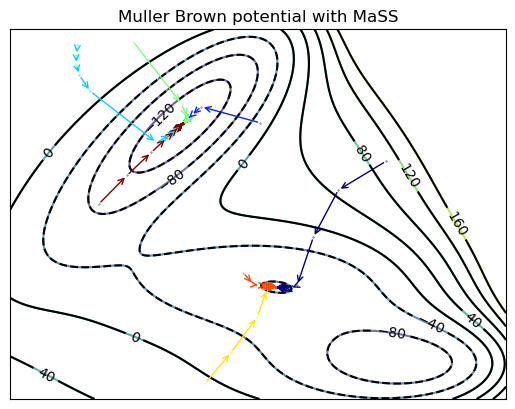

In [602]:
#MaSS

n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 20
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_MaSS = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_MaSS(intervals, learning_rate = 1e-4, a = 1)
    minima_MaSS.append(MB_potential(points_x[-1],points_y[-1]))
    if j <= 6:
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with MaSS')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

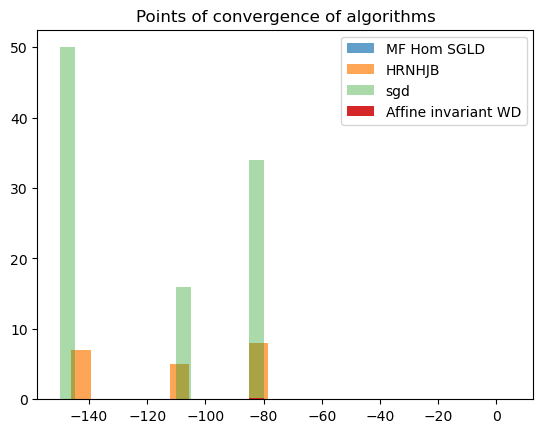

In [1496]:
bins = np.arange(-150, 10, 5)
plt.title('Points of convergence of algorithms')
plt.hist(minima_MF_Hom_SGLD, alpha = 0.7, bins = bins, density = 'True', label = 'MF Hom SGLD')
plt.hist(minima_HJB, alpha = 0.7, label = 'HRNHJB')
plt.hist(minima_sgd, alpha = 0.4, bins = bins, label = 'sgd')
plt.hist(minima, density = 'True', bins = bins, label = 'Affine invariant WD')
plt.legend()

/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/1689129583.py:15: RuntimeWarning: divide by zero encountered in log
  return -np.log(gibbs)


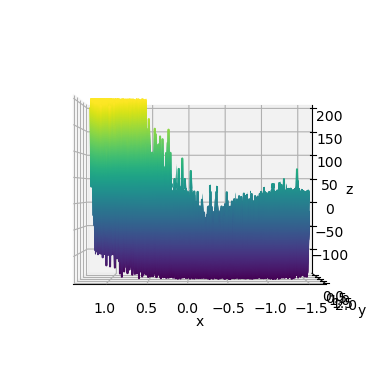

In [1475]:
#contour plot of Muller-Brown potential 
n = 256

x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

def reg_potential(x,y):
    gibbs = 0
    L = 10
    noise_x = np.random.normal(0,0.4, L)
    noise_y = np.random.normal(0,0.4, L)
    gibbs = np.mean(np.exp(-vMB_potential(x+noise_x,y+noise_y)))
        
    return -np.log(gibbs)
vreg_potential = np.vectorize(reg_potential)

Z = vreg_potential(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(0, 90)
plt.contour(X, Y, Z.clip(max = 200), 500, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Text(0, 0.5, 'y')

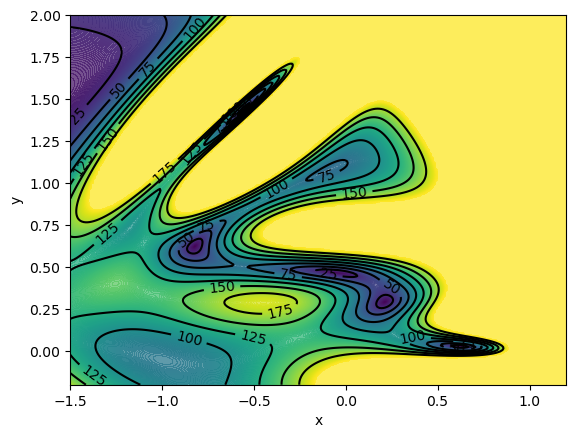

In [794]:
n = 256

x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

Z = (vgrad_MB(X, Y)[0]**2+vgrad_MB(X, Y)[1]**2)**(0.5)

plt.contourf(X, Y, Z.clip(max = 200), 500, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, Z.clip(max = 200), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

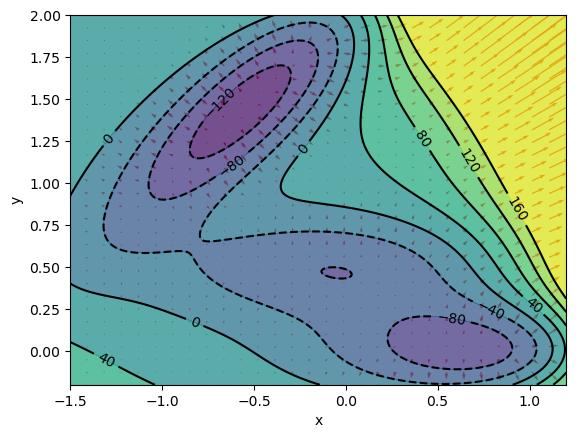

In [791]:
n = 256

x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

x1 = np.linspace(-1.5, 1.2, 30)
y1 = np.linspace(-0.2, 2, 30)
X1, Y1 = np.meshgrid(x1, y1)
U, V = vgrad_MB(X1, Y1)

plt.quiver(X1,Y1,U,V, color = 'red')
plt.contourf(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xlabel('x')
plt.ylabel('y')

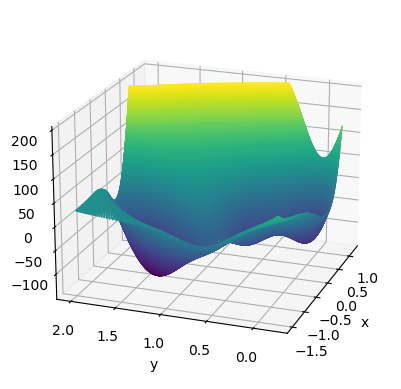

In [1384]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 200)
Z = vMB_potential(X,Y)
plt.contour(X, Y, Z.clip(max=200), 1000, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# General Observations:
- Most algorithms on the MB potential get stuck equally on two local minima, i.e. the global one (which is narrow) and the one with the next smallest local minimum
- Convolving with a solution to the heat equation does not improve performance as the narrow steep global minimum (as seen from the plot) is smeared out first thus giving no hope of real convergence, unless the algorithms is lucky with the initialisation
- The Hom-MF-SGLD works surprisingly well against all others since it performs a gradient flow of a regularised potential, where regularisation is done at the level of the gibbs measure
- Idea, maybe sample points (to initialise GD) more judiciously, i.e. with gibbs measure (inspired by Andrew Stuart's paper ) by performing a gradient flow and use that 'educated guess as the initialisation of a gd algorithm. (e.g. Wasserstein gradient flow, i.e. sgd on log of Gibbs measure of potential, or affine invariant Wasserstein)
- This idea seems to perform better that all algorithms except the MF-Hom-SGLD algorithm
- Regularising using the HJB equation (essentially performed in the MF-Hom_SGLD algorithm) is better suited to minima that are narrower compared to regularisation with the heat equation that destroys such peaks first (due to large curvature)
- Tried regularising wrt soln of HJB equation (motivated by regularising properties discussed in the 2017 paper by Chaudhari et al. entitled 'Deep Relaxation:...') directly and apply nesterov's accelerated gd algorithm with gradient restarting